In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# First read the image
original_image = cv2.imread("../../../data/lena.jpg",cv2.IMREAD_GRAYSCALE)
height,width = original_image.shape

# Step 1 
# Apply gaussian blur to the image
gaussian_blurred_image = cv2.GaussianBlur(original_image,(5,5),1.4)

# Step 2

# Now we define a x-direction sobel filter
sobel_x = np.array([
  [-1,0,1],
  [-2,0,2],
  [-1,0,1]
])

# Now we define a y-direction sobel filter
sobel_y = np.array([
  [1,2,1],
  [0,0,0],
  [-1,-2,-1]
])

# Now we convolve the image with those two filters to find the vector image
gradient_x_sobel = cv2.filter2D(gaussian_blurred_image,cv2.CV_32F,sobel_x)
gradient_y_sobel = cv2.filter2D(gaussian_blurred_image,cv2.CV_32F,sobel_y)

# Now we calculate the magnitude of the sobel vector image to find the edge map or gradient image
gradient_sobel_image = cv2.magnitude(gradient_x_sobel,gradient_y_sobel)




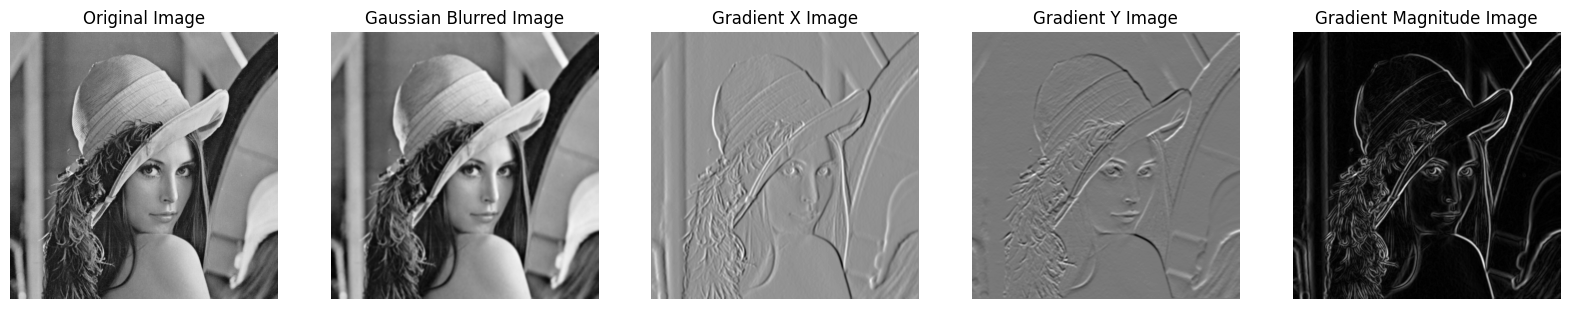

In [11]:
fig,axes = plt.subplots(1,5,figsize =(20,5))
axes[0].imshow(original_image,cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')
axes[1].imshow(gaussian_blurred_image,cmap='gray')
axes[1].set_title("Gaussian Blurred Image")
axes[1].axis('off')
axes[2].imshow(gradient_x_sobel,cmap='gray')
axes[2].set_title("Gradient X Image")
axes[2].axis('off')
axes[3].imshow(gradient_y_sobel,cmap='gray')
axes[3].set_title("Gradient Y Image")
axes[3].axis('off')
axes[4].imshow(gradient_sobel_image,cmap='gray')
axes[4].set_title("Gradient Magnitude Image")
axes[4].axis('off')


plt.show()